 <h2>Facial Keypoint Detection</h2>         
 First of all let's discuss what we are given.        
We are given three CSV files.        
training.csv :- Its has coordinates of facial keypoints like left eye, rigth eye etc and also the image.      
test.csv :- Its has image only and we have to give coordinates of various facial keypoints by looking at third csv file which is IdLookupTable.csv     
Rest everything is explained below.      
**I would really appreciate if you could upvote this kernel.**


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
import os

In [2]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow as tf
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.Session(config=config))
    
reset_keras()    

Using TensorFlow backend.
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/user1/anaconda3/lib/python3.7/site-packages/tensorflo

5


In [3]:
Train_Dir = '../input/training/training.csv'
Test_Dir = '../input/test/test.csv'
lookid_dir = '../input/IdLookupTable.csv'
train_data = pd.read_csv(Train_Dir)  
test_data = pd.read_csv(Test_Dir)
lookid_data = pd.read_csv(lookid_dir)
os.listdir('../input')

['training', 'test', 'IdLookupTable.csv', 'SampleSubmission.csv']

Lets explore our dataset

In [ ]:
train_data.head().T

Lets check for missing values

In [4]:
train_data.isnull().any().value_counts()

True     28
False     3
dtype: int64

So there are missing values in 28 columns. We can do two things here one remove the rows having missing values and another is the fill missing values with something. I used two option as removing rows will reduce our dataset. 
I filled the missing values with the previous values in that row.

In [5]:

train_data.fillna(method = 'ffill',inplace = True)
#train_data.reset_index(drop = True,inplace = True)


Lets check for missing values now

In [6]:
train_data.isnull().any().value_counts()

False    31
dtype: int64

As there is no missing values we can now separate the labels and features.
The image is our feature and other values are labes that we have to predict later.
As image column values are in string format and there is also some missing values so we have to split the string by space and append it and also handling missing values

In [7]:

imag = []
for i in range(0,7049):
    img = train_data['Image'][i].split(' ')
    img = ['0' if x == '' else x for x in img]
    imag.append(img)
    
    

Lets reshape and convert it into float value.

In [8]:
image_list = np.array(imag,dtype = 'float')
X_train = image_list.reshape(-1,96,96,1)



Lets see what is the first image.

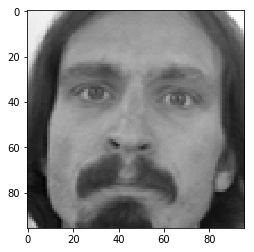

In [9]:
plt.imshow(X_train[0].reshape(96,96),cmap='gray')
plt.show()

Now lets separate labels.

In [10]:
training = train_data.drop('Image',axis = 1)

y_train = []
for i in range(0,7049):
    y = training.iloc[i,:]

    y_train.append(y)
y_train = np.array(y_train,dtype = 'float')



As our data is ready for training , lets define our model. I am using keras and simple dense layers. For loss function I am using 'mse' ( mean squared error ) as we have to predict new values. Our result evaluted on the basics of 'mae' ( mean absolute error ) . 

In [11]:
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

In [12]:
model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))



model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18432     
_________________________________________________________________
leaky_re_lu_1 (LeakyR

In [13]:
from tensorflow.keras.optimizers import Nadam
#from tensorflow.keras.optimizers.schedules import InverseTimeDecay

optimizer = Nadam(lr=0.00001,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08,
                  schedule_decay=0.004)



model.compile(loss = 'mean_squared_error', optimizer= optimizer, 
              #loss='mean_squared_error',
              metrics=['mae'])

Instructions for updating:
Use tf.cast instead.


Now our model is defined and we will train it by calling fit method. I ran it for 500 iteration keeping batch size and validtion set size as 20% ( 20% of the training data will be kept for validating the model ).

In [14]:
model.fit(X_train,y_train,epochs = 200,batch_size = 256,validation_split = 0.2)

Train on 5639 samples, validate on 1410 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
5639/5639 [==============================] - 8s 1ms/sample - loss: 2576.4796 - mean_absolute_error: 47.2687 - val_loss: 2664.1596 - val_mean_absolute_error: 48.1309
Epoch 2/200
5639/5639 [==============================] - 4s 677us/sample - loss: 2342.3792 - mean_absolute_error: 45.0581 - val_loss: 2645.2371 - val_mean_absolute_error: 47.9508
Epoch 3/200
5639/5639 [==============================] - 4s 667us/sample - loss: 2021.6760 - mean_absolute_error: 41.8019 - val_loss: 2619.0153 - val_mean_absolute_error: 47.6997
Epoch 4/200
5639/5639 [==============================] - 4s 653us/sample - loss: 1650.7569 - mean_absolute_error: 37.6352 - val_loss: 2564.7234 - val_mean_absolute_error: 47.1903
Epoch 5/200
5639/5639 [==============================] - 4s 711us/sample - loss: 1293.3591 - mean_absolute_error: 33.1060 - val_loss: 2440.9115 - val_mean_absolute_error: 46.0198
Epoch 6/200

Epoch 46/200
5639/5639 [==============================] - 3s 584us/sample - loss: 32.3839 - mean_absolute_error: 4.4385 - val_loss: 9.6466 - val_mean_absolute_error: 2.1525
Epoch 47/200
5639/5639 [==============================] - 3s 596us/sample - loss: 31.9557 - mean_absolute_error: 4.4141 - val_loss: 9.1743 - val_mean_absolute_error: 2.0719
Epoch 48/200
5639/5639 [==============================] - 3s 583us/sample - loss: 32.0128 - mean_absolute_error: 4.4187 - val_loss: 9.2002 - val_mean_absolute_error: 2.0843
Epoch 49/200
5639/5639 [==============================] - 3s 582us/sample - loss: 31.7222 - mean_absolute_error: 4.3957 - val_loss: 9.3608 - val_mean_absolute_error: 2.1094
Epoch 50/200
5639/5639 [==============================] - 3s 581us/sample - loss: 31.7392 - mean_absolute_error: 4.4019 - val_loss: 8.7125 - val_mean_absolute_error: 1.9972
Epoch 51/200
5639/5639 [==============================] - 3s 581us/sample - loss: 31.5870 - mean_absolute_error: 4.3915 - val_loss: 9.4

5639/5639 [==============================] - 3s 581us/sample - loss: 25.8855 - mean_absolute_error: 3.9587 - val_loss: 7.2831 - val_mean_absolute_error: 1.8084
Epoch 94/200
5639/5639 [==============================] - 3s 578us/sample - loss: 25.8495 - mean_absolute_error: 3.9536 - val_loss: 6.7977 - val_mean_absolute_error: 1.6945
Epoch 95/200
5639/5639 [==============================] - 3s 578us/sample - loss: 25.3954 - mean_absolute_error: 3.9210 - val_loss: 6.7967 - val_mean_absolute_error: 1.7082
Epoch 96/200
5639/5639 [==============================] - 3s 575us/sample - loss: 25.5518 - mean_absolute_error: 3.9327 - val_loss: 6.6735 - val_mean_absolute_error: 1.6699
Epoch 97/200
5639/5639 [==============================] - 3s 584us/sample - loss: 25.5875 - mean_absolute_error: 3.9298 - val_loss: 6.8206 - val_mean_absolute_error: 1.6990
Epoch 98/200
5639/5639 [==============================] - 3s 577us/sample - loss: 25.1964 - mean_absolute_error: 3.9018 - val_loss: 6.6291 - val_mea

5639/5639 [==============================] - 3s 564us/sample - loss: 20.9178 - mean_absolute_error: 3.5508 - val_loss: 6.7286 - val_mean_absolute_error: 1.7435
Epoch 141/200
5639/5639 [==============================] - 3s 579us/sample - loss: 21.0770 - mean_absolute_error: 3.5646 - val_loss: 6.5226 - val_mean_absolute_error: 1.7076
Epoch 142/200
5639/5639 [==============================] - 3s 574us/sample - loss: 20.8324 - mean_absolute_error: 3.5474 - val_loss: 6.3916 - val_mean_absolute_error: 1.6774
Epoch 143/200
5639/5639 [==============================] - 3s 567us/sample - loss: 20.7317 - mean_absolute_error: 3.5428 - val_loss: 5.6740 - val_mean_absolute_error: 1.5183
Epoch 144/200
5639/5639 [==============================] - 3s 567us/sample - loss: 20.6590 - mean_absolute_error: 3.5315 - val_loss: 6.2332 - val_mean_absolute_error: 1.6451
Epoch 145/200
5639/5639 [==============================] - 3s 565us/sample - loss: 20.6146 - mean_absolute_error: 3.5281 - val_loss: 6.3521 - va

5639/5639 [==============================] - 3s 562us/sample - loss: 17.3450 - mean_absolute_error: 3.2303 - val_loss: 6.1013 - val_mean_absolute_error: 1.6576
Epoch 188/200
5639/5639 [==============================] - 3s 564us/sample - loss: 17.3271 - mean_absolute_error: 3.2295 - val_loss: 5.5753 - val_mean_absolute_error: 1.5439
Epoch 189/200
5639/5639 [==============================] - 3s 564us/sample - loss: 17.2924 - mean_absolute_error: 3.2284 - val_loss: 6.4971 - val_mean_absolute_error: 1.7466
Epoch 190/200
5639/5639 [==============================] - 3s 562us/sample - loss: 17.1320 - mean_absolute_error: 3.2170 - val_loss: 5.6310 - val_mean_absolute_error: 1.5558
Epoch 191/200
5639/5639 [==============================] - 3s 565us/sample - loss: 17.0480 - mean_absolute_error: 3.2100 - val_loss: 7.4647 - val_mean_absolute_error: 1.9114
Epoch 192/200
5639/5639 [==============================] - 3s 563us/sample - loss: 17.1605 - mean_absolute_error: 3.2139 - val_loss: 6.3247 - va

Now lets prepare our testing data

In [ ]:
#preparing test data
timag = []
for i in range(0,1783):
    timg = test_data['Image'][i].split(' ')
    timg = ['0' if x == '' else x for x in timg]
    
    timag.append(timg)

Reshaping and converting 

In [ ]:
timage_list = np.array(timag,dtype = 'float')
X_test = timage_list.reshape(-1,96,96,1) 

Lets see first image in out test data

In [ ]:
plt.imshow(X_test[0].reshape(96,96),cmap = 'gray')
plt.show()

Lets predict our results

In [ ]:
pred = model.predict(X_test)

Now the last step is the create our submission file keeping in the mind required format.
There should be two columns :- RowId and Location
Location column values should be filled according the lookup table provided ( IdLookupTable.csv)


In [ ]:
lookid_list = list(lookid_data['FeatureName'])
imageID = list(lookid_data['ImageId']-1)
pre_list = list(pred)

In [ ]:
rowid = lookid_data['RowId']
rowid=list(rowid)

In [ ]:
feature = []
for f in list(lookid_data['FeatureName']):
    feature.append(lookid_list.index(f))

In [ ]:
preded = []
for x,y in zip(imageID,feature):
    preded.append(pre_list[x][y])

In [ ]:
rowid = pd.Series(rowid,name = 'RowId')

In [ ]:
loc = pd.Series(preded,name = 'Location')

In [ ]:
submission = pd.concat([rowid,loc],axis = 1)


In [ ]:
submission.to_csv('face_key_detection_submission.csv',index = False)